# Example
## Imports and set-up

In [34]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from sklearn.metrics import adjusted_rand_score
from noise_robust_cobras.cobras import COBRAS
from noise_robust_cobras.querier.noisy_labelquerier import ProbabilisticNoisyQuerier
from noise_robust_cobras.querier.labelquerier import LabelQuerier
from noise_robust_cobras.metric_learning.metriclearning_algorithms import SemiSupervisedMetric
from noise_robust_cobras.metric_learning.metriclearning_algorithms import SupervisedMetric
import numpy as np

def ignore_warnings():
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)
    warnings.simplefilter(action='ignore', category=Warning)

ignore_warnings()

# dataset_path = Path('iris.data').absolute()
dataset_path = Path('parkinsons.data').absolute()
assert dataset_path.exists(), f"the dataset does not exist here the root path is {Path().absolute()}"

querier_seed = 123

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's start of with loading a dataset

In [35]:
dataset = np.loadtxt(dataset_path, delimiter=',')
data = dataset[:, 1:]
target = dataset[:, 0]
print(f"data shape: {data.shape}")

data shape: (195, 13)


Create a noisy oracle to simulate a domain expert that makes some mistakes

In [10]:
noisy_querier = ProbabilisticNoisyQuerier(None, target, 0.1,100, random_seed=querier_seed)

Create a COBRAS object to cluster the data based on the supervision that the noisy querier gives:

In [11]:
clusterer = COBRAS(noise_probability=0.1,minimum_approximation_order=3, maximum_approximation_order=6)
# only store the first two return values
all_clusters, runtimes, *_ = clusterer.fit(data, -1, None, noisy_querier)
best_clustering_robust = all_clusters[-1]
runtime_robust = runtimes[-1]

Evaluate the clustering quality

In [12]:
ARI_score_robust = adjusted_rand_score(target, best_clustering_robust)
print(f"Clustering took {runtime_robust:0.3f}, ARI = {ARI_score_robust:0.3f}")

Clustering took 21.636, ARI = 0.882


For reference also run cobras with no noise handling mechanism

In [121]:
# make a new querier (take care these are statefull! so make a new querier every time)
noisy_querier = ProbabilisticNoisyQuerier(None, target, 0.1,100, random_seed=querier_seed)
querier = LabelQuerier(None, target, 10)

# make new COBRAS
clusterer = COBRAS(correct_noise=False)
all_clusters, runtimes, *_ = clusterer.fit(data, -1, None, querier)
best_clustering = all_clusters[-1]
runtime = runtimes[-1]

ARI_score = adjusted_rand_score(target, best_clustering)
print(f"Clustering took {runtime:0.3f}, ARI = {ARI_score:0.3f}")

Clustering took 1.204, ARI = 0.000


In [44]:
import os
import numpy as np
from metric_learn import ITML
from metric_learn import MMC
from metric_learn import RCA
from metric_learn import SDML
from metric_learn import LMNN
from metric_learn import NCA

path = Path('datasets/cobras-paper/').absolute()
dir_list = os.listdir(path)
string = ""
averageMetric = 0
averageNormal = 0
n = 0
for i in dir_list:
    p = os.path.join(path, i)
    dataset = np.loadtxt(p, delimiter=',')
    data = dataset[:, 1:]
    target = dataset[:, 0]

    querier = LabelQuerier(None, target, 100)

    # make new COBRAS
    clusterer = COBRAS(correct_noise=False , metric_algo=SupervisedMetric(), end = True) # baseline
    all_clusters, runtimes, *_ = clusterer.fit(data, -1, None, querier)
    newData = np.copy(clusterer.data)

    best_clustering = all_clusters[-1]

    averageNormal += adjusted_rand_score(target, best_clustering)

    # make new COBRAS
    querier = LabelQuerier(None, target, 100)
    clusterer = COBRAS(correct_noise=False , metric_algo=SupervisedMetric())
    all_clusters, runtimes, *_ = clusterer.fit(newData, -1, None, querier)
    
    best_clustering = all_clusters[-1]
    runtime = runtimes[-1]

    averageMetric += adjusted_rand_score(target, best_clustering)
    n += 1

averageMetric /= n
averageNormal /= n

print("normal: " + str(averageNormal))
print("metric_full: " + str(averageMetric))

normal: 0.5121282567221013
metric: 0.4945779999648018


In [36]:
count = 100

results = np.zeros(count)
results_metric = np.zeros(count)
results_metric_full = np.zeros(count)
x = np.arange(count)
x = x + 1

for i in range(count):
    print(i)
    querier = LabelQuerier(None, target, i + 1)

    # make new COBRAS
    clusterer = COBRAS(correct_noise=False)
    all_clusters, runtimes, *_ = clusterer.fit(data, -1, None, querier)
    best_clustering = all_clusters[-1]
    runtime = runtimes[-1]

    results[i] = adjusted_rand_score(target, best_clustering)
    
    querier = LabelQuerier(None, target, i + 1)

    # make new COBRAS
    clusterer = COBRAS(correct_noise=False, metric_algo=SupervisedMetric())
    all_clusters, runtimes, *_ = clusterer.fit(data, -1, None, querier)
    best_clustering = all_clusters[-1]
    runtime = runtimes[-1]

    results_metric_full[i] = adjusted_rand_score(target, best_clustering)

    querier = LabelQuerier(None, target, i + 1)

    # make new COBRAS
    clusterer = COBRAS(correct_noise=False, metric_algo=SemiSupervisedMetric())
    all_clusters, runtimes, *_ = clusterer.fit(data, -1, None, querier)
    best_clustering = all_clusters[-1]
    runtime = runtimes[-1]

    results_metric[i] = adjusted_rand_score(target, best_clustering)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


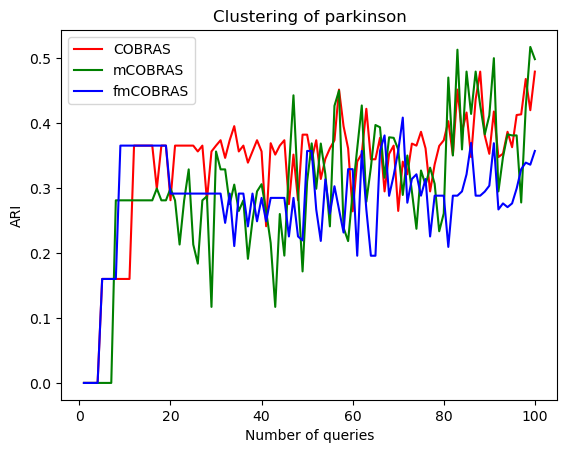

In [37]:
import matplotlib.pyplot as plt
plt.plot(x, results, color='r', label='COBRAS')
plt.plot(x, results_metric, color='g', label='mCOBRAS')
plt.plot(x, results_metric_full, color='b', label='fmCOBRAS')

plt.xlabel("Number of queries")
plt.ylabel("ARI")
plt.title("Clustering of parkinson")

plt.legend()

plt.show()

So as you can see nCOBRAS performs significantly better than COBRAS in the presence of noise.
However, the reasoning about noisy constraints takes time and thus nCOBRAS is also considerably slower than COBRAS.
